In [12]:
%load_ext autoreload
%autoreload 2

from helpers import NormalizedEnv
from helpers import RandomAgent
import gym as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn

from copy import deepcopy
from tqdm import tqdm
import importlib
from helpers import NormalizedEnv

from heuristicpolicy import HeuristicPendulumAgent
from qnetwork import QNetwork
from replaybuffer import ReplayBuffer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
#Creating pendulum object
pendulum = gym.make('Pendulum-v1', g=9.81)
#Wrapping pendulum to map output space to [-1,1]
pendulum = NormalizedEnv(pendulum)

#Create random agent
Random_Agent = RandomAgent(pendulum)

In [14]:
#set GPU for faster training
cuda = torch.cuda.is_available() #check for CUDA
device   = torch.device("cuda" if cuda else "cpu")
print("Job will run on {}".format(device))

Job will run on cpu


In [15]:
MAX_IT = 200
BUFFER_SIZE = 1e4

BATCH_SIZE = 128
LEARNING_RATE = 1e-4
NUM_EPISODES = 1000
GAMMA = 0.99

In [16]:
torch.manual_seed(-1)

heuristic_agent = HeuristicPendulumAgent(pendulum)
network  = QNetwork().to(device) # critic
memory = ReplayBuffer(max_size=BUFFER_SIZE)
q_optimizer  = optim.Adam(network.parameters(),  lr=LEARNING_RATE)

MSE = nn.MSELoss()

In [17]:
def onestepTD(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, agent, gamma, network, iter):

    state = torch.FloatTensor(np.array(state_batch)).to(device)
    action = torch.FloatTensor(np.array([action_batch])).to(device)
    reward = torch.FloatTensor(np.array(reward_batch)).unsqueeze(1).to(device) 
    trunc = torch.Tensor(np.array([np.float32(trunc_batch)])).unsqueeze(1).to(device)
    next_state = torch.FloatTensor(np.array(next_state_batch)).to(device)
    
    action_next_state = agent.compute_action(state = next_state.T) 

    # To compute the targets in each step, do not use the on-trajectory action, 
    # but compute a new action according to the policy
    
    with torch.no_grad():
        network_input_state = torch.cat((state, action.T),1)
        network_input_next_state = torch.cat((next_state, torch.Tensor(np.array([action_next_state])).T),1)
        q_next = network(network_input_next_state) # should not be differentiated 

    if iter == MAX_IT:
        q_next = 0
    target_state = reward + gamma * q_next 

    q = network(network_input_state)

    q_optimizer.zero_grad()
    q_loss = MSE(target_state, q)
    q_loss.backward()
    q_optimizer.step()

    return q_loss
    

In [19]:
plot_reward = []
plot_policy = []
plot_q = []
plot_steps = []


best_reward = -np.inf
saved_reward = -np.inf
saved_ep = 0
average_reward = 0
global_step = 0
nr_of_samples = 128


In [20]:
for episode in tqdm(range(NUM_EPISODES)):
    current_state = deepcopy(pendulum.reset()[0])

    ep_reward = 0.
    ep_q_value = 0.
    step = 0

    # collect experience
    for i in range(MAX_IT):
        # how many iterations??
        action = heuristic_agent.compute_action(state = current_state)
        transformed_action = pendulum.action(action)
        next_state, reward, term, trunc, info = pendulum.step(transformed_action)

        memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

        if memory.count() > nr_of_samples:
            # sample a batch of transitions from the replay buffer
            state_batch, action_batch, reward_batch, next_state_batch, trunc_batch = memory.sample_transition(nr_of_samples)

            # 1-step TD-learning rule
            q_loss = onestepTD(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, heuristic_agent, GAMMA, network, i)
                       
        
        current_state = deepcopy(next_state)
        ep_reward += reward
    try:
        plot_reward.append([ep_reward, episode+1])
        plot_q.append([q_loss.data, episode+1])

        if (episode % 100 == 0):
            print(q_loss.item())
    except:
        continue


  0%|          | 1/1000 [00:00<14:31,  1.15it/s]

11.748273849487305


  6%|▌         | 60/1000 [02:50<44:34,  2.85s/it]


KeyboardInterrupt: 

Text(0.5, 1.0, 'Q loss')

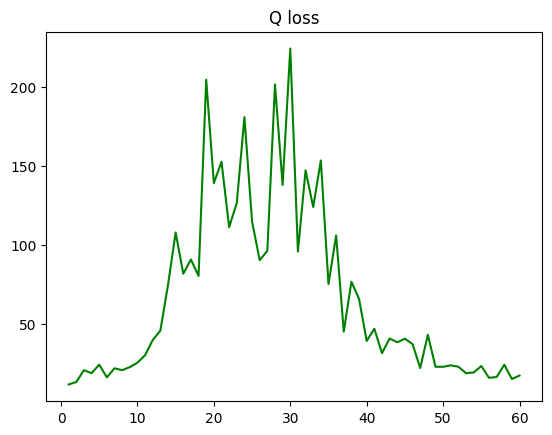

In [21]:
q = list(zip(*plot_q))
plt.plot(list(q[1]), list(q[0]), 'g') #row=0, col=1
plt.title('Q loss')